# Feature Engineer
This section documents all engineered features used to prepare the BRFSS 2023 dataset for chronic disease prediction. Each feature was selected based on public‑health relevance, interpretability, and data availability in the 2023 codebook.

## Project Structure and Workflow
This notebook begins the **feature engineering** phase of the project.
All **exploratory data analysis (EDA)** — including:

* data cleaning

* missing‑value handling

* variable inspection

* correlation analysis across all numerical variables

* initial visualizations

was completed in a **separate EDA notebook.**

After completing the EDA, the cleaned dataset was exported as: */data/brfss_2023_cleaned.csv*

**This notebook loads the cleaned dataset and continues the workflow by:**

* engineering clinically meaningful features

* creating domain‑informed transformations

* generating slide‑ready visualizations

* documenting the reasoning behind each feature

This separation keeps the workflow organized and reflects a standard data‑science pipeline:
**EDA → Feature Engineering → Modeling → Interpretation.**

In [1]:
#Environment setup
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv ('BRFSS_2023.csv')

In [5]:
df.head()

,Unnamed: 0,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,0,1.0,1.0,3012023,3,1,2023,1100.0,2023000001,2.023000e+09,...,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0,1.0,1.0,9.0
1,1,1.0,1.0,1062023,1,6,2023,1100.0,2023000002,2.023000e+09,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
2,2,1.0,1.0,3082023,3,8,2023,1100.0,2023000003,2.023000e+09,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
3,3,1.0,1.0,3062023,3,6,2023,1100.0,2023000004,2.023000e+09,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,1.0,1.0,1.0,9.0
4,4,1.0,1.0,1062023,1,6,2023,1100.0,2023000005,2.023000e+09,...,7.000000e+00,1.0,4.700000e+01,1.0,2.0,1.0,2.0,1.0,1.0,2.0


**Making sure that no columns got accidentally dropped**

In [7]:
# See columns (quick scan)
df.columns.tolist()[:50], len(df.columns)

(['Unnamed: 0',
  '_STATE',
  'FMONTH',
  'IDATE',
  'IMONTH',
  'IDAY',
  'IYEAR',
  'DISPCODE',
  'SEQNO',
  '_PSU',
  'CTELENM1',
  'PVTRESD1',
  'COLGHOUS',
  'STATERE1',
  'CELPHON1',
  'LADULT1',
  'NUMADULT',
  'RESPSLC1',
  'LANDSEX2',
  'LNDSXBRT',
  'SAFETIME',
  'CTELNUM1',
  'CELLFON5',
  'CADULT1',
  'CELLSEX2',
  'CELSXBRT',
  'PVTRESD3',
  'CCLGHOUS',
  'CSTATE1',
  'LANDLINE',
  'HHADULT',
  'SEXVAR',
  'GENHLTH',
  'PHYSHLTH',
  'MENTHLTH',
  'POORHLTH',
  'PRIMINS1',
  'PERSDOC3',
  'MEDCOST1',
  'CHECKUP1',
  'EXERANY2',
  'EXRACT12',
  'EXEROFT1',
  'EXERHMM1',
  'EXRACT22',
  'EXEROFT2',
  'EXERHMM2',
  'STRENGTH',
  'BPHIGH6',
  'BPMEDS1'],
 351)

## 1. Target Variable: ANY_CHRONIC

**Description:**
A binary indicator representing whether a respondent has any of the major chronic conditions captured in BRFSS 2023.

**Source variables:**

DIABETE4 (Diabetes)

CHCCOPD3 (COPD)

CVDCRHD4 (Coronary heart disease)

CHCKDNY2 (Kidney disease)

CVDSTRK3 (Stroke)

CHCOCNC1 (Other cancer)

**Engineering logic:**

Convert each condition to 1 = “Yes”, 0 = “No”, NaN = missing.

Take the row‑wise maximum to indicate whether any condition is present.

**Why it matters:** 

Combining multiple chronic conditions into a single binary target simplifies modeling and aligns with public‑health goals of identifying individuals at elevated risk.

In [12]:
# Chronic disease variables from BRFSS 2023
chronic_vars = [
    "DIABETE4",   # Diabetes
    "CHCCOPD3",   # COPD
    "CVDCRHD4",   # Coronary heart disease
    "CHCKDNY2",   # Kidney disease
    "CVDSTRK3",   # Stroke
    "CHCOCNC1"    # Other cancer
]

# Convert BRFSS chronic disease responses to binary:
# 1 = Yes, 2 = No, everything else = NaN
df[chronic_vars] = df[chronic_vars].applymap(
    lambda x: 1 if x == 1 else 0 if x == 2 else np.nan
)

# Create the target variable: ANY chronic condition
df["ANY_CHRONIC"] = df[chronic_vars].max(axis=1)


C:\Users\climi\AppData\Local\Temp\ipykernel_7768\2779034863.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[chronic_vars] = df[chronic_vars].applymap(


## 2. Missing Code Standardization

**Description:**
BRFSS uses special numeric codes (7, 9, 77, 99, etc.) to represent “Don’t know,” “Refused,” or missing responses.

**Engineering logic:**

Replace all BRFSS missing codes with NaN.

**Why it matters:** 

Standardizing missing values ensures consistent handling during preprocessing and prevents incorrect interpretation of missing responses as valid categories.

In [10]:
missing_codes = [7, 9, 77, 99, 777, 999]
df = df.replace(missing_codes, np.nan)

## 3. Behavioral Features

***A) Active***
**Description:**  
Binary indicator of whether the respondent engaged in any physical activity in the past 30 days.

**Source variable:** EXERANY2

* 1 = Yes

* 2 = No

**Why it matters:** 
Physical inactivity is a major modifiable risk factor for chronic disease.

In [11]:
df["ACTIVE"] = df["EXERANY2"].apply(lambda x: 1 if x == 1 else 0)

**B) Smoker Description:**  
Binary indicator of whether the respondent has smoked at least 100 cigarettes in their lifetime.

**Source variable:** SMOKE100

* 1 = Yes

* 2 = No

**Why it matters:** 
Smoking is strongly associated with cardiovascular disease, cancer, and COPD.

In [12]:
df["SMOKER"] = df["SMOKE100"].apply(lambda x: 1 if x == 1 else 0)

***C) Heavy Drinker***
**Description:**  
Binary indicator of heavy alcohol consumption.

**Source variable:** DRNK3GE5

* 1 = Yes

* 2 = No

**Why it matters:** 
Heavy drinking increases risk for liver disease, hypertension, and several chronic conditions.

In [13]:
df["HEAVY_DRINKER"] = df["DRNK3GE5"].apply(lambda x: 1 if x == 1 else 0)


## 4. Health Status Features

### A) BMI (Continuous) and BMI Category (Categorical)

**Description:** 
BRFSS provides two BMI‑related variables:
* **_BMI5** — computed BMI multiplied by 100 (continuous)

* **_BMI5CAT** — CDC‑defined four‑category BMI classification (categorical)

**Engineering steps:**

* 1. Convert **_BMI5** to a true BMI value by dividing by 100.

* 2. Map **_BMI5CAT** to readable category labels:

**Categories:**

* Underweight

* Normal

* Overweight

* Obese

**Why it matters:**

Using both continuous BMI and categorical BMI allows the model to capture linear and nonlinear relationships with chronic disease risk. The categorical version also aligns with CDC public‑health standards.

In [7]:
# Convert BRFSS BMI (x100) to real BMI
df["BMI"] = df["_BMI5"] / 100

# Map official BRFSS BMI categories to readable labels
bmi_map = {
    1: "Underweight",
    2: "Normal",
    3: "Overweight",
    4: "Obese"
}

df["BMI_CAT"] = df["_BMI5CAT"].map(bmi_map)


### B) STRESS_SCORE

**Description:**
Ordinal measure of how often the respondent felt stressed in the past 30 days.

**Source variable:** SDHSTRE1

* 1 = Always

* 2 = Usually

* 3 = Sometimes

* 4 = Rarely

* 5 = Never

**Engineering logic:** 
Reverse‑coded so higher values represent higher stress.

**Why it matters:** 
Stress is strongly linked to chronic disease through pathways involving inflammation, sleep disruption, and behavioral risk factors.

In [14]:
# Clean missing codes
df["SDHSTRE1"] = df["SDHSTRE1"].replace([7, 9], np.nan)

# Ordinal stress score (higher = more stress)
stress_map = {
    1: 5,  # Always stressed
    2: 4,  # Usually
    3: 3,  # Sometimes
    4: 2,  # Rarely
    5: 1   # Never
}

df["STRESS_SCORE"] = df["SDHSTRE1"].map(stress_map)


### C) GENHLTH_SCORE

**Description**  
Ordinal encoding of self‑reported general health.

**Source variable:** GENHLTH

* 1 = Excellent

* 2 = Very good

* 3 = Good

* 4 = Fair

* 5 = Poor

**Engineering logic:**  
Reverse‑coded so higher values represent better health.

**Why it matters:** 
Self‑rated health is a validated predictor of morbidity and mortality.

In [15]:
health_map = {1:5, 2:4, 3:3, 4:2, 5:1}
df["GENHLTH_SCORE"] = df["GENHLTH"].map(health_map)

#### D) Mental & Physical Health Days

Already numeric:

PHYSHLTH

MENTHLTH

No transformation needed.

**Description:** 
Numeric counts of days in the past 30 days when physical or mental health was “not good.”

**Why they matter:**  
These variables capture the burden of poor health and are strong predictors of chronic disease risk.

## 5. Demographic Features

**AGEG5YR:**
Age grouped in 5‑year intervals.
Age is one of the strongest predictors of chronic disease.

**SEX:**
Biological sex (male/female).
Chronic disease prevalence differs significantly by sex.

**EDUCA:**
Education level.
Education is a key social determinant of health.

**INCOME2:**
Income bracket.
Income influences access to care, stress, and health behaviors.

## 6. Final Feature Set

**Description**
The final engineered feature set includes a mix of continuous, categorical, behavioral, health‑status, and demographic variables. These features were selected based on public‑health relevance, interpretability, and their availability in the BRFSS 2023 dataset.

**BMI Features**

* **BMI** — continuous BMI value derived from _BMI5 (BMI × 100).

* **BMI_CAT** — categorical BMI classification derived from _BMI5CAT (Underweight, Normal, Overweight, Obese).

**Behavioral Features**

* **ACTIVE** — physical activity in the past 30 days.

* **SMOKER** — lifetime cigarette use (≥100 cigarettes).

* **HEAVY_DRINKER** — heavy alcohol consumption indicator.

**Health Status Features**

* **STRESS_SCORE** — ordinal stress level based on SDHSTRE1.

* **GENHLTH_SCORE** — ordinal self‑rated general health.

* **PHYSHLTH** — days of poor physical health in the past 30 days.

* **MENTHLTH** — days of poor mental health in the past 30 days.

**Demographic Features**

* **AGEG5YR** — age grouped in 5‑year intervals.

* **SEX** — biological sex.

* **EDUCA** — education level.

* **INCOME2** — income bracket.

These features collectively capture behavioral risk factors, health status, and social determinants that are strongly associated with chronic disease risk.

In [16]:
features = [
    # BMI features
    "BMI",          # Continuous BMI (converted from _BMI5)
    "BMI_CAT",      # Categorical BMI (mapped from _BMI5CAT)

    # Behavioral features
    "ACTIVE",
    "SMOKER",
    "HEAVY_DRINKER",

    # Health status features
    "STRESS_SCORE",
    "GENHLTH_SCORE",
    "PHYSHLTH",
    "MENTHLTH",

    # Demographics
    "AGEG5YR",
    "SEX",
    "EDUCA",
    "INCOME2"
]


# Body Mass Index (BMI and BMI Categories)
This section processes BMI in both continuous and categorical forms using BRFSS 2023 variables to capture different aspects of weight‑related health risk.

* **Source variables:**

  * **_BMI5** → continuous BMI

  * **BMI5CAT** → CDC BMI categories (Underweight, Normal, Overweight, Obesity)

* **Transformations:**

  * Continuous BMI is scaled from _BMI5 (value ÷ 100).

  * Categorical BMI is mapped to CDC‑defined weight classes.

* **Visualizations:**

  * Histogram of continuous BMI distribution

  * Bar chart of CDC BMI categories with percentages

* **Rationale:**

   * Continuous BMI preserves fine‑grained variation and is useful for models that assume numeric relationships.

  * Categorical BMI captures nonlinear risk patterns (e.g., obesity risk jumps sharply).

  * Using both forms improves interpretability and allows downstream models to detect both linear and threshold‑based effects.


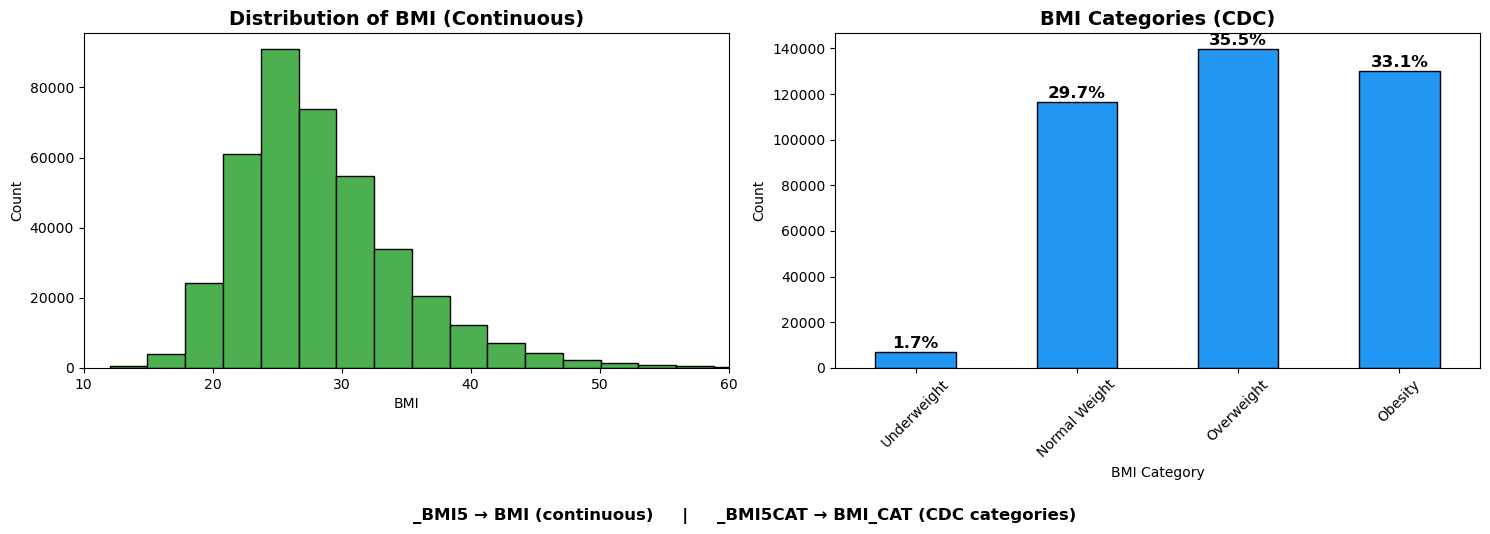

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Create BMI and BMI_CAT from BRFSS variables ---

# Convert _BMI5 (stored as 100 * BMI) to actual BMI
df['BMI'] = df['_BMI5'] / 100

# Map _BMI5CAT to readable CDC categories
bmi_cat_map = {
    1: "Underweight",
    2: "Normal Weight",
    3: "Overweight",
    4: "Obesity"
}

df['BMI_CAT'] = df['_BMI5CAT'].map(bmi_cat_map)

# --- 2. Create the two visuals ---

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Histogram of continuous BMI ---
axes[0].hist(df['BMI'].dropna(), bins=30, color="#4CAF50", edgecolor="black")
axes[0].set_title("Distribution of BMI (Continuous)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("BMI")
axes[0].set_ylabel("Count")

# Optional polish: limit x-axis to remove extreme outliers
axes[0].set_xlim(10, 60)

# --- Bar chart of BMI categories ---
counts = df['BMI_CAT'].value_counts().reindex(bmi_cat_map.values())
counts.plot(
    kind='bar',
    ax=axes[1],
    color="#2196F3",
    edgecolor="black"
)

axes[1].set_title("BMI Categories (CDC)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("BMI Category")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

# --- Add percentage labels on top of bars ---
total = counts.sum()
for i, value in enumerate(counts):
    pct = (value / total) * 100
    axes[1].text(i, value + (total * 0.005), f"{pct:.1f}%", 
                 ha='center', fontsize=12, fontweight='semibold')

plt.tight_layout()

# --- Caption under the figure ---
plt.figtext(0.5, -0.05,
            "_BMI5 → BMI (continuous)     |     _BMI5CAT → BMI_CAT (CDC categories)",
            ha='center', fontsize=12, fontweight='semibold')

plt.show()


# Physical Activity Status (ACTIVE)
This section encodes physical activity as a binary behavioral variable.

**How the code works**
* **EXERANY2** is recoded into **ACTIVE** (1 = exercised in past 30 days, 0 = inactive).

* A bar chart visualizes the proportion of active vs. inactive respondents.

**Why this matters**
* Physical activity is a clinically meaningful modifiable risk factor.

* The binary encoding aligns with CDC guidelines and simplifies interpretation.

* This variable helps quantify lifestyle patterns that strongly influence chronic disease risk.

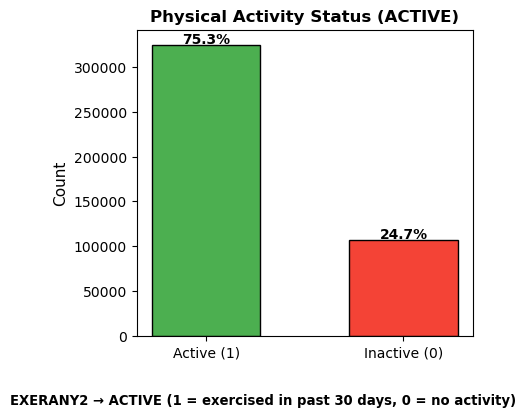

In [6]:

# --- 1. Create ACTIVE from EXERANY2 ---
df['ACTIVE'] = df['EXERANY2'].map({1: 1, 2: 0})

# --- 2. Count ACTIVE vs INACTIVE ---
counts = df['ACTIVE'].value_counts().reindex([1, 0])
labels = ["Active (1)", "Inactive (0)"]

# --- 3. Create smaller bar chart ---
fig, ax = plt.subplots(figsize=(4.5, 3.8))   # <<< smaller figure

bars = ax.bar(labels, counts, 
              color=["#4CAF50", "#F44336"], 
              edgecolor="black",
              width=0.55)                    # <<< slightly narrower bars

# Title and labels
ax.set_title("Physical Activity Status (ACTIVE)", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=11)

# --- 4. Add percentage labels ---
total = counts.sum()
for i, value in enumerate(counts):
    pct = (value / total) * 100
    ax.text(i, value + (total * 0.003), f"{pct:.1f}%", 
            ha='center', fontsize=10, fontweight='semibold')

plt.tight_layout()

# --- 5. Caption under the figure ---
plt.figtext(
    0.5, -0.08,
    "EXERANY2 → ACTIVE (1 = exercised in past 30 days, 0 = no activity)",
    ha='center', fontsize=9.5, fontweight='semibold'
)

plt.show()


# Smoking History (SMOKER)
This section creates a binary exposure variable for lifetime smoking.

**How the code works**
* **SMOKE100** is recoded into **SMOKER** (1 = smoked ≥100 cigarettes, 0 = never smoked).

* A bar chart displays the distribution of smokers vs. non‑smokers.

**Why this matters**
* Smoking is one of the most powerful predictors of cardiovascular, respiratory, and cancer outcomes.

* The ≥100‑cigarette threshold is a standard epidemiological definition of “ever smoker.”

* This variable captures long‑term exposure rather than short‑term behavior.

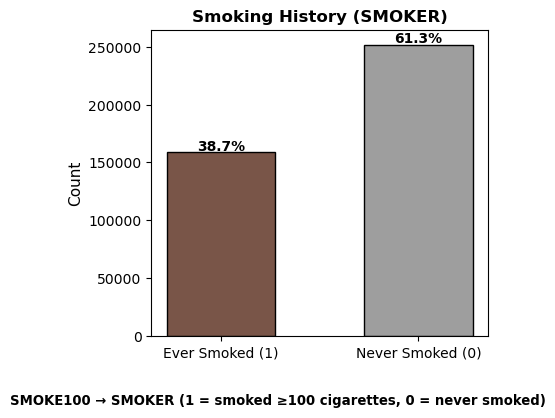

In [5]:
# --- 1. Create SMOKER from SMOKE100 ---
# SMOKE100: 1 = Yes (smoked 100+ cigarettes), 2 = No
df['SMOKER'] = df['SMOKE100'].map({1: 1, 2: 0})

# --- 2. Count SMOKER vs NON-SMOKER ---
counts = df['SMOKER'].value_counts().reindex([1, 0])
labels = ["Ever Smoked (1)", "Never Smoked (0)"]

# --- 3. Create smaller bar chart for slides ---
fig, ax = plt.subplots(figsize=(4.5, 3.8))

bars = ax.bar(
    labels,
    counts,
    color=["#795548", "#9E9E9E"],   # brown for smokers, gray for non-smokers
    edgecolor="black",
    width=0.55
)

# Title and labels
ax.set_title("Smoking History (SMOKER)", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=11)

# --- 4. Add percentage labels ---
total = counts.sum()
for i, value in enumerate(counts):
    pct = (value / total) * 100
    ax.text(
        i,
        value + (total * 0.003),
        f"{pct:.1f}%",
        ha='center',
        fontsize=10,
        fontweight='semibold'
    )

plt.tight_layout()

# --- 5. Caption under the figure ---
plt.figtext(
    0.5,
    -0.08,
    "SMOKE100 → SMOKER (1 = smoked ≥100 cigarettes, 0 = never smoked)",
    ha='center',
    fontsize=9.5,
    fontweight='semibold'
)

plt.show()


# Heavy Alcohol Use (HEAVY_DRINKER)
This section defines a behavioral risk indicator for heavy drinking.

**How the code works**
* **DRNK3GE5** is recoded into HEAVY_DRINKER (1 = heavy drinking, 0 = not heavy drinking).

* A bar chart visualizes the prevalence of heavy alcohol use.

**Why this matters**
* Heavy alcohol use contributes to metabolic, hepatic, and cardiovascular disease risk.

* The BRFSS threshold aligns with clinical definitions of heavy drinking.

* This variable captures a **modifiable behavior** that interacts with other risk factors.

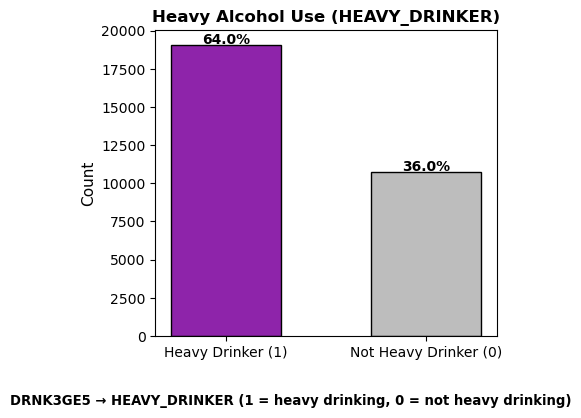

In [6]:
# --- 1. Create HEAVY_DRINKER from DRNK3GE5 ---
# DRNK3GE5: 1 = Yes (heavy drinking), 2 = No
df['HEAVY_DRINKER'] = df['DRNK3GE5'].map({1: 1, 2: 0})

# --- 2. Count heavy drinkers vs non-heavy drinkers ---
counts = df['HEAVY_DRINKER'].value_counts().reindex([1, 0])
labels = ["Heavy Drinker (1)", "Not Heavy Drinker (0)"]

# --- 3. Create smaller bar chart for slides ---
fig, ax = plt.subplots(figsize=(4.5, 3.8))

bars = ax.bar(
    labels,
    counts,
    color=["#8E24AA", "#BDBDBD"],   # purple for heavy drinking, gray for no
    edgecolor="black",
    width=0.55
)

# Title and labels
ax.set_title("Heavy Alcohol Use (HEAVY_DRINKER)", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=11)

# --- 4. Add percentage labels ---
total = counts.sum()
for i, value in enumerate(counts):
    pct = (value / total) * 100
    ax.text(
        i,
        value + (total * 0.003),
        f"{pct:.1f}%",
        ha='center',
        fontsize=10,
        fontweight='semibold'
    )

plt.tight_layout()

# --- 5. Caption under the figure ---
plt.figtext(
    0.5,
    -0.08,
    "DRNK3GE5 → HEAVY_DRINKER (1 = heavy drinking, 0 = not heavy drinking)",
    ha='center',
    fontsize=9.5,
    fontweight='semibold'
)

plt.show()


# Stress Score (STRESS_LEVEL)
This section quantifies psychological strain using BRFSS stress data.

**How the code works**
* **SDHSTRE1** is mapped to an ordinal stress score (0 = Never → 4 = Always).

* **Two visualizations are produced:**

  * A bar chart of stress levels

  * A boxplot comparing stress scores for individuals with vs. without chronic disease

**Why this matters**
* Stress is a **validated predictor** of chronic disease and health‑related behaviors.

* Higher stress scores correlate with higher chronic disease burden.

* The ordinal scale preserves meaningful gradations in psychological strain.

In [8]:
!pip install seaborn

C:\Users\climi\AppData\Local\Temp\ipykernel_7768\972989595.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\climi\AppData\Local\Temp\ipykernel_7768\972989595.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


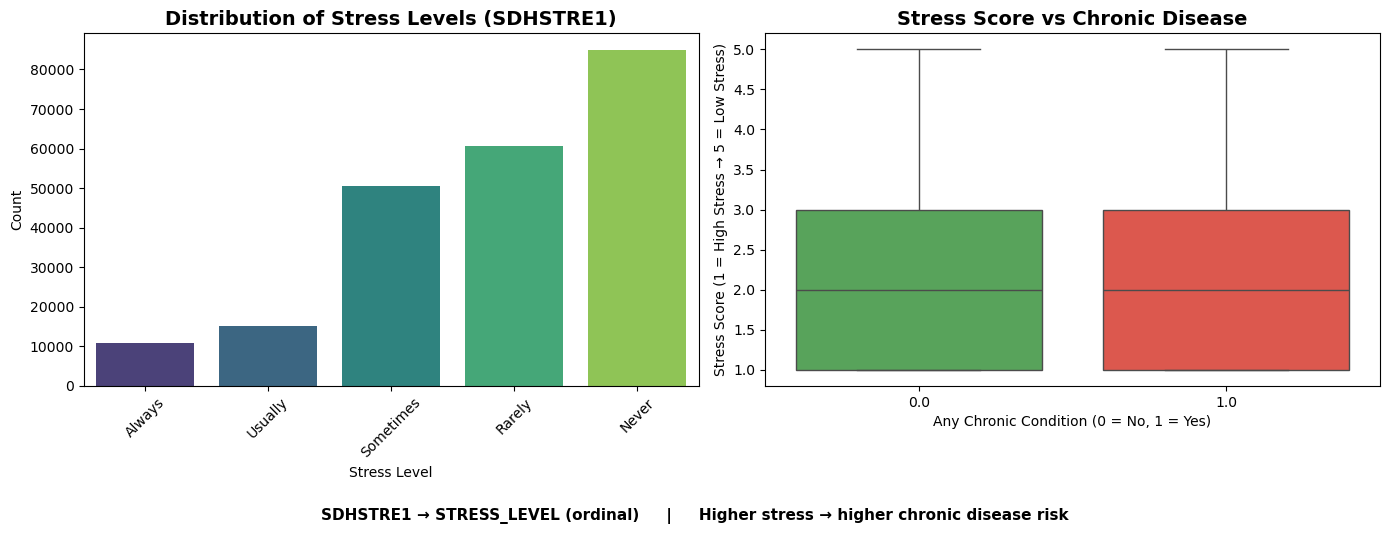

In [17]:
import seaborn as sns

# --- 1. Stress score preparation ---
# SDHSTRE1 is ordinal: 1 = Always, 2 = Usually, 3 = Sometimes, 4 = Rarely, 5 = Never
stress_map = {
    1: "Always",
    2: "Usually",
    3: "Sometimes",
    4: "Rarely",
    5: "Never"
}

df['STRESS_LEVEL'] = df['SDHSTRE1'].map(stress_map)

# STRESS_SCORE is assumed already created (1–5 scale)
# ANY_CHRONIC is your binary target (1 = has ≥1 chronic condition)

# --- 2. Create the two visuals ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Bar chart of SDHSTRE1 distribution ---
order = ["Always", "Usually", "Sometimes", "Rarely", "Never"]

sns.countplot(
    data=df,
    x='STRESS_LEVEL',
    order=order,
    ax=axes[0],
    palette="viridis"
)

axes[0].set_title("Distribution of Stress Levels (SDHSTRE1)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Stress Level")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# --- Boxplot: STRESS_SCORE vs ANY_CHRONIC ---
sns.boxplot(
    data=df,
    x='ANY_CHRONIC',
    y='STRESS_SCORE',
    ax=axes[1],
    palette=["#4CAF50", "#F44336"]  # green = no chronic, red = chronic
)

axes[1].set_title("Stress Score vs Chronic Disease", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Any Chronic Condition (0 = No, 1 = Yes)")
axes[1].set_ylabel("Stress Score (1 = High Stress → 5 = Low Stress)")

plt.tight_layout()

# --- Caption under the figure ---
plt.figtext(
    0.5,
    -0.05,
    "SDHSTRE1 → STRESS_LEVEL (ordinal)     |     Higher stress → higher chronic disease risk",
    ha='center',
    fontsize=11,
    fontweight='semibold'
)

plt.show()


# Self‑Rated General Health (GENHLTH_SCORE)
This section processes self‑rated general health, a powerful predictor of morbidity.

**How the code works**
* **GENHLTH** is recoded into an ordinal score.

* The scale is reverse‑coded so higher values = worse health.

* A bar chart visualizes the distribution of health categories.

**Why this matters**
* Self‑rated health is one of the strongest single predictors of morbidity and mortality.

* Reverse‑coding aligns the direction of the scale with other risk indicators (higher = worse).

* This improves interpretability in both visualizations and modeling.

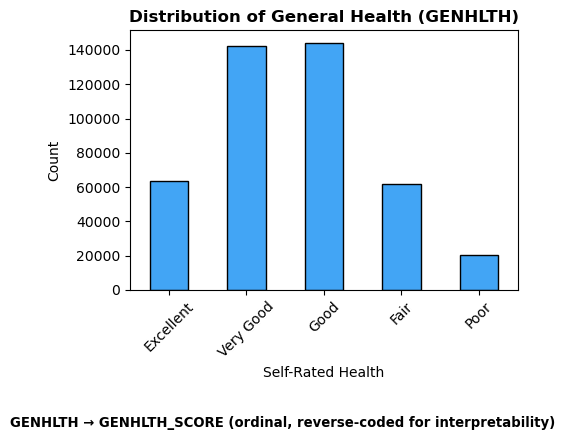

In [18]:
# --- 1. Clean and map GENHLTH (self-rated general health) ---

# GENHLTH coding:
# 1 = Excellent
# 2 = Very good
# 3 = Good
# 4 = Fair
# 5 = Poor
# 7, 9 = Missing

df['GENHLTH'] = df['GENHLTH'].replace([7, 9], pd.NA)

# Create readable labels
genhlth_map = {
    1: "Excellent",
    2: "Very Good",
    3: "Good",
    4: "Fair",
    5: "Poor"
}

df['GENHLTH_LABEL'] = df['GENHLTH'].map(genhlth_map)

# --- 2. Reverse-code GENHLTH_SCORE for interpretability ---
# Higher score = better health
reverse_map = {
    1: 5,  # Excellent
    2: 4,  # Very Good
    3: 3,  # Good
    4: 2,  # Fair
    5: 1   # Poor
}

df['GENHLTH_SCORE'] = df['GENHLTH'].map(reverse_map)

# --- 3. Create bar chart of GENHLTH distribution ---
fig, ax = plt.subplots(figsize=(5, 4))

order = ["Excellent", "Very Good", "Good", "Fair", "Poor"]

df['GENHLTH_LABEL'].value_counts().reindex(order).plot(
    kind='bar',
    ax=ax,
    color="#42A5F5",
    edgecolor="black"
)

ax.set_title("Distribution of General Health (GENHLTH)", fontsize=12, fontweight='bold')
ax.set_xlabel("Self-Rated Health")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

# --- 4. Caption under the figure ---
plt.figtext(
    0.5,
    -0.08,
    "GENHLTH → GENHLTH_SCORE (ordinal, reverse-coded for interpretability)",
    ha='center',
    fontsize=9.5,
    fontweight='semibold'
)

plt.show()


# Poor Physical and Mental Health Days
This section uses BRFSS functional limitation measures.

**How the code works**
* **PHYSHLTH** and **MENTHLTH** are kept as numeric counts (0–30 days).

* Two bar charts show the distribution of poor physical and poor mental health days.

**Why this matters**
* These variables quantify functional impairment, not just diagnoses.

* Higher counts reflect greater limitations in daily functioning.

* They capture quality‑of‑life dimensions strongly correlated with chronic disease.

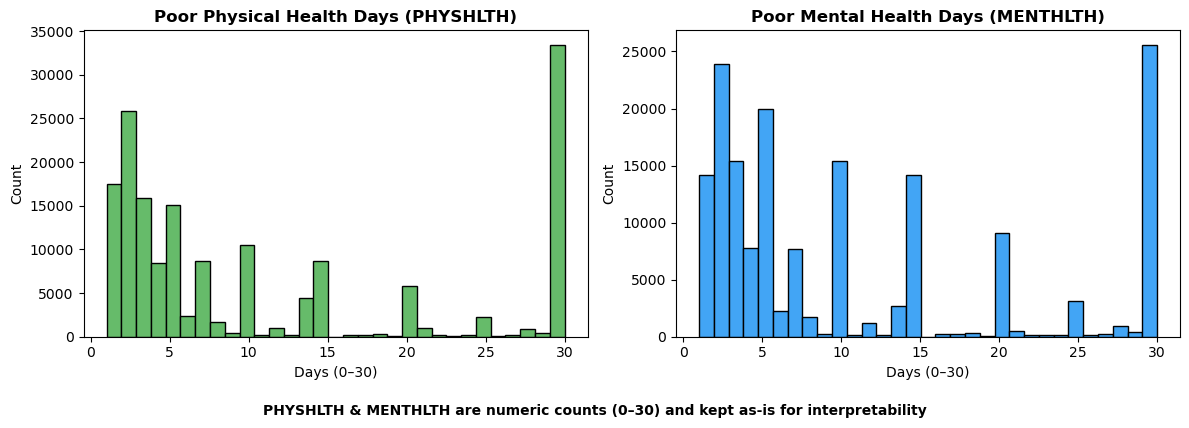

In [19]:

# --- 1. Clean missing values for PHYSHLTH and MENTHLTH ---
# BRFSS uses 88, 77, 99 as missing codes
df['PHYSHLTH'] = df['PHYSHLTH'].replace([77, 88, 99], pd.NA)
df['MENTHLTH'] = df['MENTHLTH'].replace([77, 88, 99], pd.NA)

# --- 2. Create two histograms side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram: Poor Physical Health Days
axes[0].hist(
    df['PHYSHLTH'].dropna(),
    bins=31,
    color="#66BB6A",
    edgecolor="black"
)
axes[0].set_title("Poor Physical Health Days (PHYSHLTH)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Days (0–30)")
axes[0].set_ylabel("Count")

# Histogram: Poor Mental Health Days
axes[1].hist(
    df['MENTHLTH'].dropna(),
    bins=31,
    color="#42A5F5",
    edgecolor="black"
)
axes[1].set_title("Poor Mental Health Days (MENTHLTH)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Days (0–30)")
axes[1].set_ylabel("Count")

plt.tight_layout()

# --- 3. Caption under the figure ---
plt.figtext(
    0.5,
    -0.05,
    "PHYSHLTH & MENTHLTH are numeric counts (0–30) and kept as-is for interpretability",
    ha='center',
    fontsize=10,
    fontweight='semibold'
)

plt.show()


# Demographic Breakdown (Age, Sex, Education, Income)
This section summarizes key demographic variables in a single 2×2 figure.

**How the code works**
* **_AGE80, LANDSEX2, EDUCA,** and **INCOME3** are cleaned and mapped to readable labels.

* A 2×2 grid visualizes:

  * Age distribution

  * Sex distribution

  * Education levels

  * Income categories

* Spacing, label rotation, and bin width are adjusted for readability.

**Why this matters**
Demographics capture social determinants of health that shape chronic disease disparities.

Age, sex, education, and income contextualize the population and influence risk patterns.

Presenting them together provides a clear, interpretable overview of the dataset.

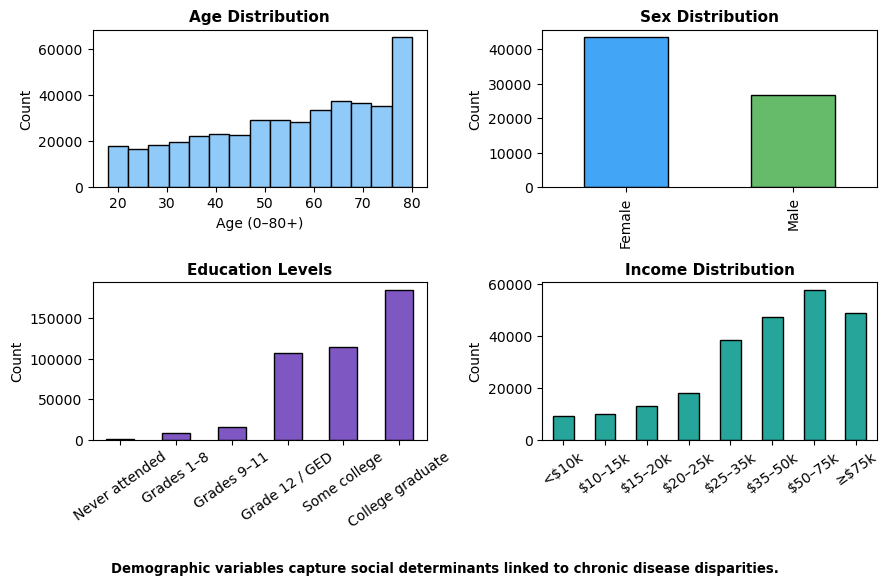

In [25]:
# --- 1. Clean demographic variables ---

# SEX (landline version): 1 = Male, 2 = Female
df['SEX_LABEL'] = df['LANDSEX2'].map({1: "Male", 2: "Female"})

# EDUCATION (EDUCA)
educ_map = {
    1: "Never attended",
    2: "Grades 1–8",
    3: "Grades 9–11",
    4: "Grade 12 / GED",
    5: "Some college",
    6: "College graduate"
}
df['EDU_LABEL'] = df['EDUCA'].map(educ_map)

# INCOME (INCOME3)
income_map = {
    1: "<$10k",
    2: "$10–15k",
    3: "$15–20k",
    4: "$20–25k",
    5: "$25–35k",
    6: "$35–50k",
    7: "$50–75k",
    8: "≥$75k"
}
df['INCOME_LABEL'] = df['INCOME3'].map(income_map)

# --- 2. Create 2×2 demographic chart (smaller figure) ---
fig, axes = plt.subplots(2, 2, figsize=(9, 5.5))

# Add more vertical spacing between top and bottom rows
plt.subplots_adjust(hspace=0.35)

# AGE histogram (bins reduced from 20 → 15)
axes[0, 0].hist(
    df['_AGE80'].dropna(),
    bins=15,
    color="#90CAF9",
    edgecolor="black"
)
axes[0, 0].set_title("Age Distribution", fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel("Age (0–80+)")
axes[0, 0].set_ylabel("Count")

# SEX bar chart
df['SEX_LABEL'].value_counts().plot(
    kind='bar',
    ax=axes[0, 1],
    color=["#42A5F5", "#66BB6A"],
    edgecolor="black"
)
axes[0, 1].set_title("Sex Distribution", fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("Count")

# EDUCATION bar chart (rotation reduced to 35°)
df['EDU_LABEL'].value_counts().reindex(educ_map.values()).plot(
    kind='bar',
    ax=axes[1, 0],
    color="#7E57C2",
    edgecolor="black"
)
axes[1, 0].set_title("Education Levels", fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis='x', rotation=35)

# INCOME bar chart (rotation reduced to 35°)
df['INCOME_LABEL'].value_counts().reindex(income_map.values()).plot(
    kind='bar',
    ax=axes[1, 1],
    color="#26A69A",
    edgecolor="black"
)
axes[1, 1].set_title("Income Distribution", fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel("")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='x', rotation=35)

plt.tight_layout()

# Caption
plt.figtext(
    0.5,
    -0.05,
    "Demographic variables capture social determinants linked to chronic disease disparities.",
    ha='center',
    fontsize=9.5,
    fontweight='semibold'
)

plt.show()
